#**HURRICANE CHAOS GAME**

PART III
```
Miriam Nohemi López Cruz
Vrije Universiteit Brussel, Belgium
Email: miriam.nohemi.lopez.cruz@vub.be
```

In this notebook, we will obtain the activations from the intermediate layers of a pre-trained network (VGG-16) on the ImageNet dataset. Then, we will  when passing the images of the Hurricane Chaos game.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
# Import the required packages
from PIL import Image
import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create the folder structure for the target dataset

In [ ]:
# Load the dataset with clutter-metrics evaluated images.
hc = pd.read_csv(path+'hurricane_game.csv')

In [ ]:
# Split into train and validation sets (e.g., 80% train, 20% validation)
train, val = train_test_split(hc, test_size=0.2, stratify=hc['theme'], random_state=42)

# Verify the splits
print(f"Train: {len(train)}, Validation: {len(val)}")

Train: 6059, Validation: 1515


In [ ]:
# Target folder where images will be sorted into themes
#!mkdir  /content/drive/MyDrive/target_dataset
target_folder = path+'target_dataset'


In [ ]:
# Create train and val folders
for split in ['train', 'val']:
    split_path = os.path.join(target_folder, split)
    os.makedirs(split_path, exist_ok=True)

    # Create subfolders for each theme:
    for theme in hc['theme'].unique():
      os.makedirs(os.path.join(split_path, theme), exist_ok=True)

Move images into the corresponding folders

In [ ]:
# Folder where your hurricane game images are stored
source_folder = path+'hurricanescenes'

# Function to move files into the appropriate folder
def move_files(split_df, split_name):
    for _, row in split_df.iterrows():
        file_name = str(row['id'])+'.png'
        theme = row['theme']

        # Construct source and target paths
        source_path = os.path.join(source_folder, file_name)
        target_path = os.path.join(target_folder, split_name, theme, file_name)

        # Move the file if it exists
        if os.path.exists(source_path):
            shutil.move(source_path, target_path)
            print(f"Moved {file_name} to {split_name}/{theme}/")
        else:
            print(f"File {file_name} not found in {source_folder}!")

# Move files for train and validation sets
move_files(train, 'train')
move_files(val, 'val')


Streaming output truncated to the last 5000 lines.
File 2103867.png not found in /content/drive/MyDrive/hurricanescenes!
File 1323287.png not found in /content/drive/MyDrive/hurricanescenes!
File 908562.png not found in /content/drive/MyDrive/hurricanescenes!
File 1799140.png not found in /content/drive/MyDrive/hurricanescenes!
File 1298047.png not found in /content/drive/MyDrive/hurricanescenes!
File 1011371.png not found in /content/drive/MyDrive/hurricanescenes!
File 2140159.png not found in /content/drive/MyDrive/hurricanescenes!
File 1771603.png not found in /content/drive/MyDrive/hurricanescenes!
File 1843764.png not found in /content/drive/MyDrive/hurricanescenes!
File 2268906.png not found in /content/drive/MyDrive/hurricanescenes!
File 2522995.png not found in /content/drive/MyDrive/hurricanescenes!
File 1692161.png not found in /content/drive/MyDrive/hurricanescenes!
File 2320247.png not found in /content/drive/MyDrive/hurricanescenes!
File 2539292.png not found in /content/d

## Import PyTorch Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


In [ ]:
from __future__ import print_function, division
import time
import copy

plt.ion()   # interactive mode

## Initialize hyperparameters

In [ ]:
batch_size = 4
num_epochs = 25
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 1: Load the dataset

Target data: Hurricane Chaos game dataset, divided into train and val folder, each divided by the respective 5 themes.

In [ ]:
transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_dir = target_folder
train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4)

train_size = len(train_set)
val_size = len(val_set)

classes = train_set.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print(train_size)
print(val_size)

5868
1402


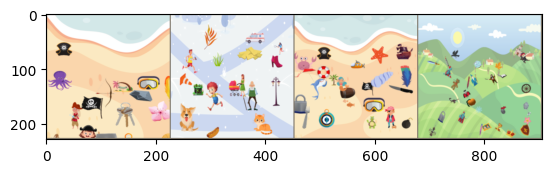

Pirates CityOldKids Pirates FantasyOldKids


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Step 2: Model training

In this step, we will load a pretrained model from the Pytorch <code>models</code> library and use it as a base model for our classifier.

# Transfer Learning via Fine Tuning

In [ ]:
# Loading the pre-trained model, get the number of input features going into the
# final fully connected layer and replace the classifier to output 5 classes,
# corresponding to the 5 themes in the Hurricane Chaos dataset.

model_ft = models.vgg16(weights='DEFAULT')

num_features = model_ft.classifier[6].in_features
model_ft.fc = nn.Linear(num_features, 5)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001, betas=(0.5, 0.999))

### Define the training loop for

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print("Starting Training Loop...")
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        # training
        running_loss = 0.0
        running_accuracy = 0
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        train_loss = running_loss / train_size
        train_acc = running_accuracy.double() / train_size

        # validation
        running_loss = 0.0
        running_accuracy = 0
        model.eval()
        # Specify the layers to extract activations from
        layers_of_interest = ['features.5', 'features.10', 'features.17']
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_accuracy += torch.sum(preds == labels.data)
            val_loss = running_loss / val_size
            val_acc = running_accuracy.double() / val_size
            # deep copy the model
            if val_acc > best_acc:
                best_acc = val_acc
                model_weights = copy.deepcopy(model.state_dict())

        print('[%d/%d]\ttrain loss: %.4f\ttrain accuracy: %.4f\t -- val loss: %.4f\tval accuracy: %.4f'
                  % (epoch, num_epochs, train_loss, train_acc, val_loss, val_acc))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(model_weights)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=20)

Starting Training Loop...
[0/20]	train loss: 0.6002	train accuracy: 0.8299	 -- val loss: 0.3519	val accuracy: 0.9073
[1/20]	train loss: 0.3620	train accuracy: 0.9047	 -- val loss: 0.3855	val accuracy: 0.8994
[2/20]	train loss: 0.3210	train accuracy: 0.9153	 -- val loss: 0.2390	val accuracy: 0.9322
[3/20]	train loss: 0.2849	train accuracy: 0.9240	 -- val loss: 0.3121	val accuracy: 0.9187
[4/20]	train loss: 0.3054	train accuracy: 0.9204	 -- val loss: 0.2303	val accuracy: 0.9387
[5/20]	train loss: 0.2833	train accuracy: 0.9269	 -- val loss: 0.2156	val accuracy: 0.9408
[6/20]	train loss: 0.2556	train accuracy: 0.9310	 -- val loss: 0.2430	val accuracy: 0.9330
[7/20]	train loss: 0.2513	train accuracy: 0.9347	 -- val loss: 0.2066	val accuracy: 0.9387
[8/20]	train loss: 0.2549	train accuracy: 0.9291	 -- val loss: 0.2814	val accuracy: 0.9301
[9/20]	train loss: 0.2605	train accuracy: 0.9293	 -- val loss: 0.2217	val accuracy: 0.9451
[10/20]	train loss: 0.2315	train accuracy: 0.9378	 -- val loss: 

## Step 3: Feature Visualization

In [ ]:
model_ft.features[23]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
#Function to find all MaxPool layers within the VGG-16 model

def get_all_conv_layers(model):
    conv_layers = []
    model_weights = []
    counter = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.MaxPool2d):
            conv_layers.append(module)
            counter += 1
            # MaxPool2d layers don't have weights, so skip appending to model_weights
            # model_weights.append(module.weight)
    return conv_layers, counter, model_weights # model_weights will be empty

conv_layers, counter, model_weights = get_all_conv_layers(model_ft)
print(conv_layers)
print(f"Num. of MaxPool layers:{counter}")

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
Num. of MaxPool layers:5


### **Register a forward hook**

We need to register a forward hook to the desired layers (max-pooling layer in this case) to capture the activations during the forward pass.

In [ ]:
activation = {}  # Dictionary to store activations

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Find the 4th MaxPool2d layer in model_ft.features and register the hook
for name, module in model_ft.named_modules():
    if isinstance(module, nn.MaxPool2d):  # Check for MaxPool2d layers
        module.register_forward_hook(get_activation(name))
        #break  # Register hook to the first MaxPool2d layer and break


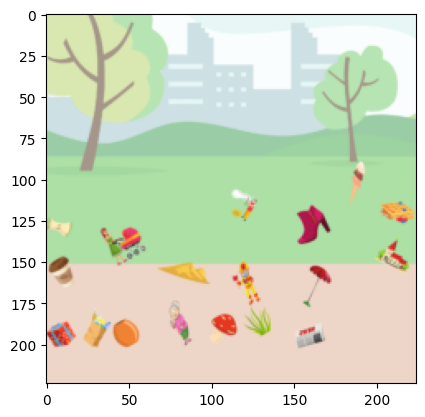

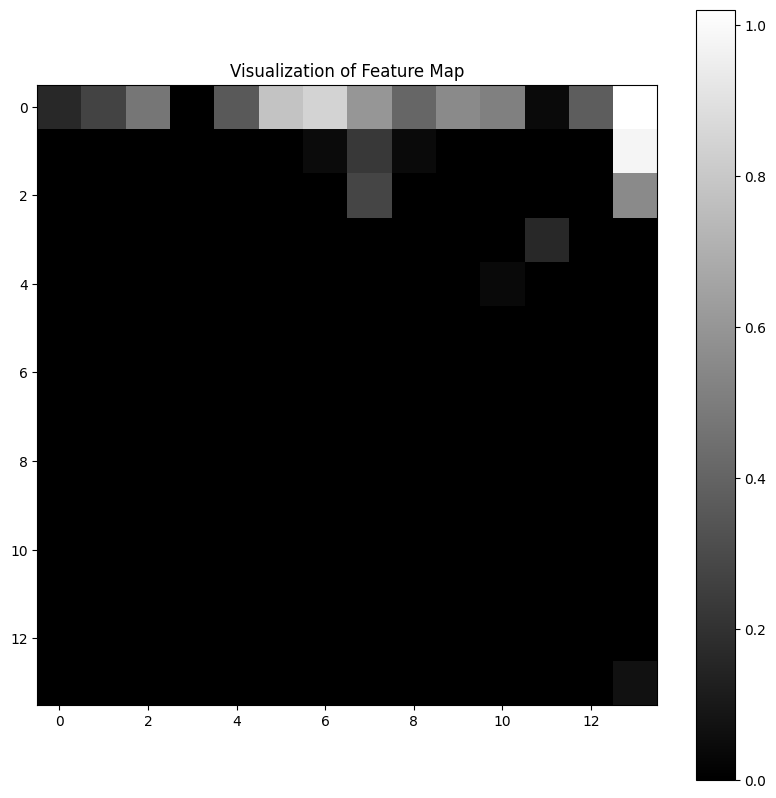

In [ ]:
images, _ = next(iter(train_loader))
test_image = images[0,:,:,:].unsqueeze(0).to(device) # Move test_image to the device
imshow(images[0,:,:,:])

# Obtain the activation for the test image
with torch.no_grad():
    model_ft(test_image)  # Pass the test image through the model
activation_energy_pool1 = activation['features.4']
activation_energy_pool3 = activation['features.16']
activation_energy_pool4 = activation['features.23']

# Select a specific feature map to visualize (e.g., the second one)
feature_map_to_visualize = activation_energy_pool4[0, 1, :, :]

# Visualize the selected feature map
plt.figure(figsize=(10, 10))
plt.imshow(feature_map_to_visualize.cpu(), cmap='gray')
plt.colorbar()
plt.title('Visualization of Feature Map')
plt.show()


In [ ]:
print(activation.keys())
print(activation['features.23'])
print(activation['features.23'].shape)

dict_keys(['features.4', 'features.9', 'features.16', 'features.23', 'features.30'])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1609, 0.2692, 0.4729,  ..., 0.0407, 0.3743, 1.0209],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9787],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5536],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0703]],

         [[0.0000, 0.6972, 1.0175,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.00

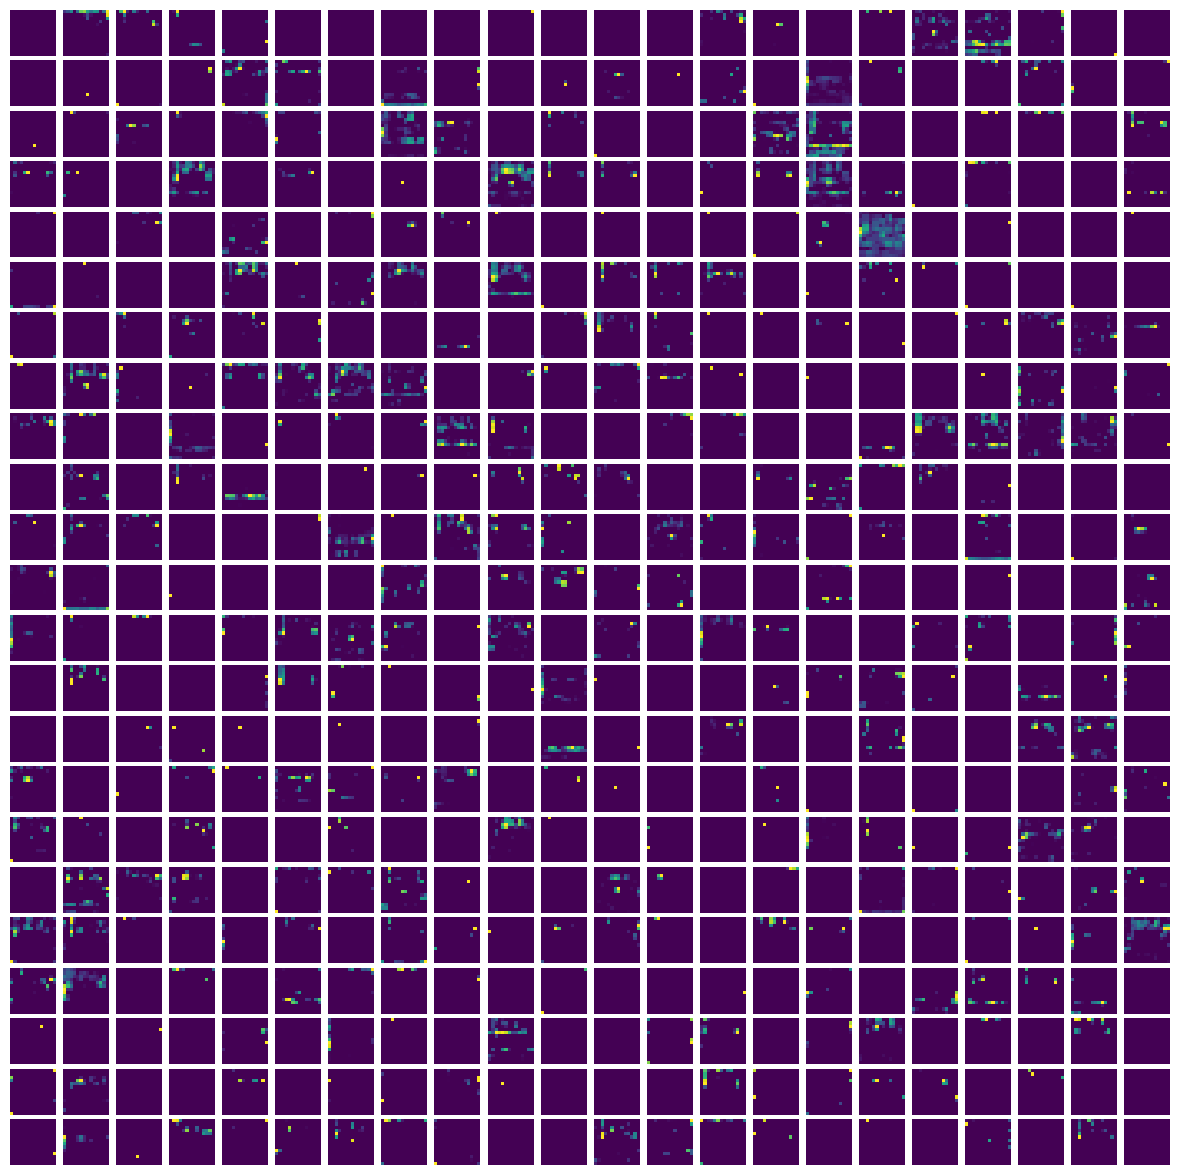

In [ ]:
# Visualize the feature maps
num_maps = activation_energy_pool4.size(1)  # Number of channels

# Create a grid of subplots
num_cols = int(num_maps**0.5)
num_rows = num_cols + (num_maps % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()

# Plot each feature map
for i, feature_map in enumerate(activation_energy_pool4[0]):
  if i < len(axes):  # Ensure enough subplots
    axes[i].imshow(feature_map.cpu(), cmap='viridis')
    axes[i].axis('off')

plt.show()  # Display the grid

# **Energy map**

torch.Size([1, 28, 28])


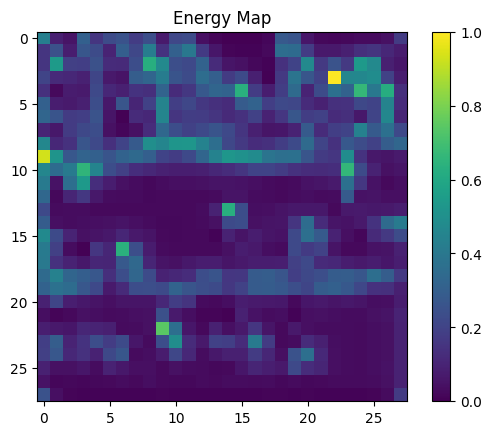

In [ ]:
import torch
# Visualize the energy maps

# Assuming activation_energy_pool4 is a tensor of shape (batch_size, num_channels, height, width)

# Average over the channels:
energy_map = torch.mean(activation_energy_pool3, dim=1)  # Average across dimension 1 (channels)
print(energy_map.shape)
#energy_map_firstmaxpool = torch.mean(activation_energy_pool4, dim=1)  # Average across dimension 1 (channels)

# Normalize to the range [0, 1]:
energy_map_normalized = (energy_map - energy_map.min()) / (energy_map.max() - energy_map.min())

# 3. Visualize using matplotlib:
plt.imshow(energy_map_normalized[0].cpu().numpy(), cmap='viridis')  # Visualize the first image in the batch
plt.colorbar()  # Add a colorbar to show the energy scale
plt.title('Energy Map')
plt.show()

# **Unsupervised activation energy**

In [ ]:
# Assuming activation_energy_pool4 is a tensor of shape (batch_size, num_channels, height, width)

# Calculate the average across all dimensions:
unsupervised_activation_energy = torch.mean(activation_energy_pool4)

# Print or use the unsupervised activation energy
print(f"Unsupervised Activation Energy: {unsupervised_activation_energy.item()}")

Unsupervised Activation Energy: 0.02622981369495392


In [ ]:
all_filenames = []  # Initialize an empty list to store all filenames

# Iterate through all batches in the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    # Iterate through each image in the current batch
    for i in range(images.size(0)):
        # Extract the filename using the index in train_set.samples
        img_file = train_set.samples[batch_idx * train_loader.batch_size + i][0][-11:]
        try:
          all_filenames.append(img_file)
        except Exception as e:
          print(f"An error occurred while opening the image {img_file}: {e}")

#print(all_filenames)  # Print the list of all filenames

In [ ]:
len(all_filenames)

5868

In [ ]:
train_loader_dataset = []  # Initialize an empty list to store all filenames, mean activations and mean activation accross channels
activation = {}  # Dictionary to store activations

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Find the 4th MaxPool2d layer in model_ft.features and register the hook
for name, module in model_ft.named_modules():
    if isinstance(module, nn.MaxPool2d):  # Check for MaxPool layers
        module.register_forward_hook(get_activation(name))

# Process images in batches
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)  # Ensure model is on the correct device
model_ft.eval()  # Set the model to evaluation mode

# Iterate through all batches in the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    # Iterate through each image in the current batch
    for i in range(images.size(0)):
        # Extract the filename using the index in train_set.samples
        img_file = train_set.samples[batch_idx * train_loader.batch_size + i][0][-11:]
        try:
          # Access the individual image tensor from the batch
          input_image = images[i].unsqueeze(0).to(device)
          with torch.no_grad():
            model_ft(input_image)  # Pass the test image through the model
          activation_energy_pool3 = activation['features.16']
          activation_energy_pool4 = activation['features.23']
          #feature_map_weights = activation_energy_pool4.cpu().squeeze().numpy()  # Remove batch dimension
          unsupervised_activation_energy3 = torch.mean(activation_energy_pool3)
          unsupervised_activation_energy4 = torch.mean(activation_energy_pool4)
          energy_map = torch.mean(activation_energy_pool3, dim=1)
          # Append the filename and flattened weights to the dataset
          train_loader_dataset.append({
            "filename": img_file,
            "uae_maxpool3": float(unsupervised_activation_energy3.cpu()),
            "uae_maxpool4": float(unsupervised_activation_energy4.cpu()),
            "energy_map_maxpool3": energy_map.cpu().squeeze().numpy().flatten().tolist()
            })
        except Exception as e:
          print(f"An error occurred while opening the image {img_file}: {e}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
val_loader_dataset = []

# Iterate through all batches in the val_loader
for batch_idx, (images, labels) in enumerate(val_loader):
    # Iterate through each image in the current batch
    for i in range(images.size(0)):
        activation = {}  # Dictionary to store activations
        # Extract the filename using the index in train_set.samples
        img_file = val_set.samples[batch_idx * val_loader.batch_size + i][0][-11:]
        # Access the individual image tensor from the batch
        input_image = images[i].unsqueeze(0).to(device)
        with torch.no_grad():
          model_ft(input_image)  # Pass the test image through the model
        activation_energy_pool3 = activation['features.16']
        activation_energy_pool4 = activation['features.23']
        #feature_map_weights = activation_energy_pool4.cpu().squeeze().numpy()  # Remove batch dimension
        unsupervised_activation_energy3 = torch.mean(activation_energy_pool3)
        unsupervised_activation_energy4 = torch.mean(activation_energy_pool4)
        energy_map = torch.mean(activation_energy_pool3, dim=1)
        # Append the filename and flattened weights to the dataset
        val_loader_dataset.append({
          "filename": img_file,
          "uae_maxpool3": float(unsupervised_activation_energy3.cpu()),
          "uae_maxpool4": float(unsupervised_activation_energy4.cpu()),
          "energy_map_maxpool3": energy_map.cpu().squeeze().numpy().flatten().tolist()
          })

In [ ]:
print(train_loader_dataset[0])
print(val_loader_dataset[0])

{'filename': '1004846.png', 'uae_maxpool3': 0.06531193852424622, 'uae_maxpool4': 0.021448995918035507, 'energy_map_maxpool3': [0.12748821079730988, 0.03982528671622276, 0.04956195503473282, 0.06668790429830551, 0.05963055044412613, 0.041485026478767395, 0.08071141690015793, 0.13757914304733276, 0.11254129558801651, 0.06087461858987808, 0.06925877928733826, 0.11394800990819931, 0.18208986520767212, 0.16626444458961487, 0.15621855854988098, 0.08101951330900192, 0.07810771465301514, 0.09467057883739471, 0.10069004446268082, 0.14510312676429749, 0.14309200644493103, 0.15064865350723267, 0.18076345324516296, 0.10976824164390564, 0.057289279997348785, 0.06138540804386139, 0.08181758224964142, 0.06945962458848953, 0.028295008465647697, 0.0199967660009861, 0.012416811659932137, 0.002481175120919943, 0.002651476301252842, 0.010572603903710842, 0.0492660328745842, 0.05578923225402832, 0.058038994669914246, 0.040260761976242065, 0.0594424307346344, 0.12278231978416443, 0.161921888589859, 0.110442

In [ ]:
print(len(train_loader_dataset))
print(len(train_loader_dataset[0]['energy_map_maxpool3']))
print(len(val_loader_dataset))
print(len(val_loader_dataset[0]['energy_map_maxpool3']))

5868
784
1402
784


In [ ]:
# Convert the new datasets to DataFrames
df_train = pd.DataFrame(train_loader_dataset)
df_val = pd.DataFrame(val_loader_dataset)

In [ ]:
# Concatenate dataframes
concat_df_trainet = pd.concat([df_train, df_val], ignore_index=True)

# Adjust filename column to same format as the other datasets
concat_df_trainet["filename"] = concat_df_trainet["filename"].str.strip("/")
concat_df_trainet["filename"] = concat_df_trainet["filename"].str.strip(".png")
concat_df_trainet["id"] = concat_df_trainet["filename"].astype(int)

print(concat_df_trainet.shape)

(7270, 5)


In [ ]:
concat_df_trainet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7270 entries, 0 to 7269
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             7270 non-null   object 
 1   uae_maxpool3         7270 non-null   float64
 2   uae_maxpool4         7270 non-null   float64
 3   energy_map_maxpool3  7270 non-null   object 
 4   id                   7270 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 284.1+ KB


In [ ]:
# Convert to csv file
pd.DataFrame.to_csv(concat_df_trainet,"/content/drive/MyDrive/df_trainet.csv", index=False)

In [ ]:
concat_df_trainet.head()

,filename,uae_maxpool3,uae_maxpool4,energy_map_maxpool3,id
0,1004846,0.065312,0.021449,"[0.12748821079730988, 0.03982528671622276, 0.0...",1004846
1,1005332,0.060279,0.022352,"[0.0733150765299797, 0.014282762072980404, 0.0...",1005332
2,1009126,0.038582,0.010538,"[0.07261362671852112, 0.014300759881734848, 0....",1009126
3,1010665,0.077244,0.018657,"[0.16970933973789215, 0.06839354336261749, 0.0...",1010665
4,1011552,0.087493,0.028886,"[0.1924435794353485, 0.17662984132766724, 0.16...",1011552


In [ ]:
from torchvision import transforms
from PIL import Image

In [ ]:
dataset = []
activation = {}  # Dictionary to store activations

#for image, _ in next(iter(train_loader)):
  #test_image = image[0,:,:,:].unsqueeze(0).to(device) # Move test_image to the device

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Find the 4th MaxPool2d layer in model_ft.features and register the hook
for name, module in model_ft.named_modules():
    if isinstance(module, nn.MaxPool2d):  # Check for MaxPool2d layers
        module.register_forward_hook(get_activation(name))
        #break  # Register hook to the first MaxPool2d layer and break


image = Image.open("/content/hch_scenes/train/1006879.png").convert('RGB')
# Apply transformations
input_image = transforms(image).unsqueeze(0).to(device)


with torch.no_grad():
  model_ft(input_image)  # Pass the test image through the model
activation_energy_pool1 = activation['features.4']
activation_energy_pool2 = activation['features.9']
activation_energy_pool3 = activation['features.23']
activation_energy_pool4 = activation['features.30']

#feature_map_weights = activation_energy_pool4.cpu().squeeze().numpy()  # Remove batch dimension
unsupervised_activation_energy = torch.mean(activation_energy_pool4)
energy_map = torch.mean(activation_energy_pool1, dim=1)

# Append the filename and flattened weights to the dataset
dataset.append({
    "filename": img_file,
    "unsupervised_activation_energy": float(unsupervised_activation_energy.cpu()),
    "energy_map": energy_map.cpu().squeeze().numpy().flatten().tolist()
    })



FileNotFoundError: [Errno 2] No such file or directory: '/content/hch_scenes/train/1006879.png'